# Document Enrichment

---

## Setup Notebook

We will be using the [Amazon Textract Parser Library](https://github.com/aws-samples/amazon-textract-response-parser/tree/master/src-python) for parsing through the Textract response, data science library [Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) for content analysis, the [Amazon SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/), and [AWS boto3 python sdk](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) to work with Amazon Textract and Amazon A2I. Let's now install and import them.

In [10]:
!python -m pip install -q amazon-textract-overlayer --force-reinstall

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
conda 4.13.0 requires ruamel_yaml_conda>=0.11.14, which is not installed.
docker-compose 1.29.2 requires PyYAML<6,>=3.10, but you have pyyaml 6.0 which is incompatible.
awscli 1.25.27 requires botocore==1.27.27, but you have botocore 1.27.65 which is incompatible.
awscli 1.25.27 requires PyYAML<5.5,>=3.10, but you have pyyaml 6.0 which is incompatible.
awscli 1.25.27 requires rsa<4.8,>=3.1.2, but you have rsa 4.8 which is incompatible.
aiobotocore 2.3.4 requires botocore<1.24.22,>=1.24.21, but you have botocore 1.27.65 which is incompatible.


In [1]:
from textractcaller.t_call import call_textract, Textract_Features, Textract_Types
from textractprettyprinter.t_pretty_print import Textract_Pretty_Print, get_string, Pretty_Print_Table_Format
from trp.trp2 import TDocument

In [2]:
import boto3
import botocore
import sagemaker
import os
import io
import datetime
import json
import pandas as pd
from PIL import Image as PImage, ImageDraw
from pathlib import Path
import multiprocessing as mp
from IPython.display import Image, display, HTML, JSON, IFrame
from trp import Document

# variables
data_bucket = sagemaker.Session().default_bucket()
region = boto3.session.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

os.environ["BUCKET"] = data_bucket
os.environ["REGION"] = region
role = sagemaker.get_execution_role()

print(f"SageMaker role is: {role}\nDefault SageMaker Bucket: s3://{data_bucket}")

s3=boto3.client('s3')
textract = boto3.client('textract', region_name=region)
comprehend=boto3.client('comprehend', region_name=region)


SageMaker role is: arn:aws:iam::159664259931:role/IDPCfnStack-SageMakerExecutionRole-1NZJF84HAQF6I
Default SageMaker Bucket: s3://sagemaker-us-east-2-159664259931


---
## Redact PII in Medical Transcription letter

In this step we will first detect PII (Personally Identifiable Information) in our sample Medical transcription letter. We will then extract the bounding box information for the detected PII entities and create redaction bounding boxes on the document.

In order to obtain the bounding box geometry of all words from the document we will use a helper tool called `amazon-textract-overlayer`. See [documentation](https://github.com/aws-samples/amazon-textract-textractor/tree/master/overlayer) to learn more about `amazon-textract-overlayer`.

Let's look at the un-redacted document -

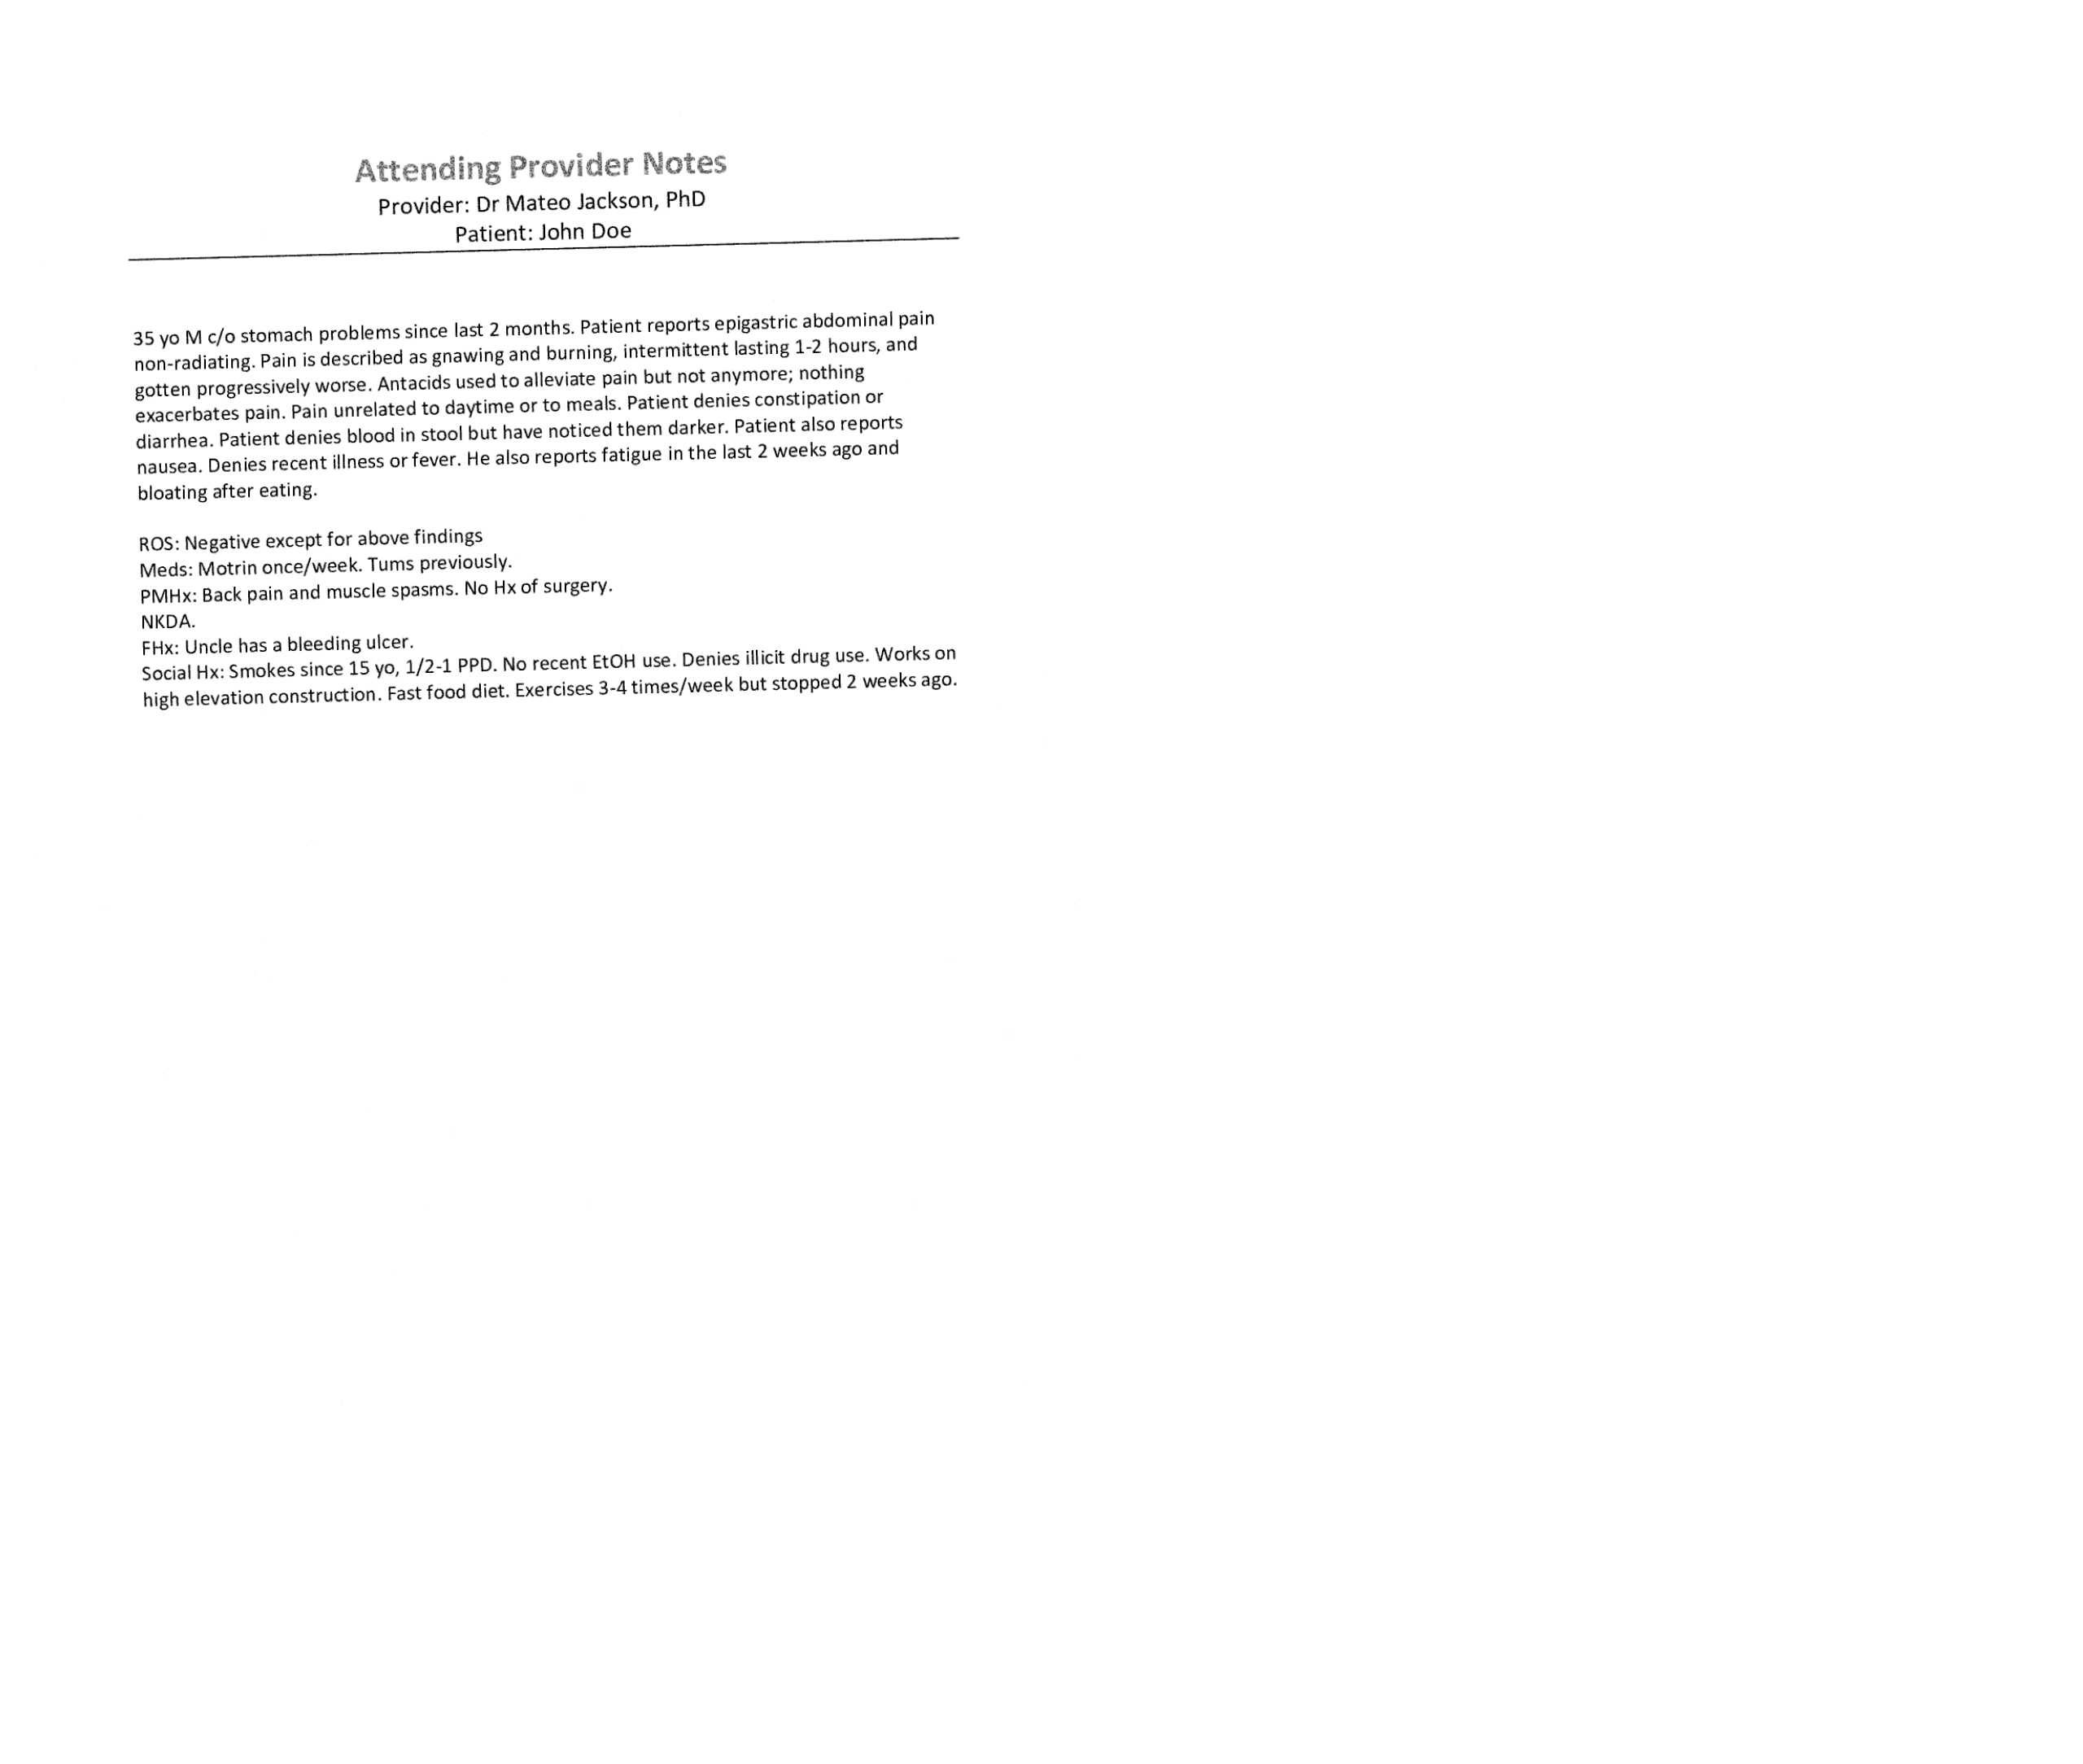

In [10]:
documentName = "./dataset/document_samples/dr-note-sample.png"
display(Image(filename=documentName, width=900))

### Detecting PII Entities

Let's take a look at how to detect PII entities using Amazon Comprehend Detect PII Entities API. Amazon Comprehend's PII detection API uses a pre-trained NLP model that can detect most common PII entities such as NAME, AGE, ADDRESS, SSN, DATE and so on (for a full list see [documentation](https://docs.aws.amazon.com/comprehend/latest/dg/how-pii.html#how-pii-types)).

In [11]:
#upload to S3
key='idp/textract/dr-note-sample.png'
s3.upload_file(Filename='./dataset/document_samples/dr-note-sample.png', 
               Bucket=data_bucket, 
               Key=key)

In [12]:
resp = call_textract(input_document = f's3://{data_bucket}/idp/textract/dr-note-sample.png')
text = get_string(textract_json=resp, output_type=[Textract_Pretty_Print.LINES])

#Call Amazon Comprehend Detect PII Entities API
entity_resp = comprehend.detect_pii_entities(Text=text, LanguageCode="en")    

pii = []
for entity in entity_resp['Entities']:
    pii_entity={}
    pii_entity['Type'] = entity['Type']
    pii_entity['Text'] = text[entity['BeginOffset']:entity['EndOffset']]
    pii.append(pii_entity)
pii 

[{'Type': 'NAME', 'Text': 'Mateo Jackson, PhD'},
 {'Type': 'NAME', 'Text': 'John Doe'},
 {'Type': 'AGE', 'Text': '35'}]

---
### Perform Document Enrichment

Using a combination of Amazon Comprehend and Amazon Textract we can now perform some PII redaction on the Medical transcription document. Next we will define a helper function that will

1. Call Amazon Textract to get the plain text information from the Paystub and the corresponding bounding box information since it is an image file
2. Use the extracted text to call Amazon Comprehend's [Detect PII](https://docs.aws.amazon.com/comprehend/latest/dg/how-pii.html) API
3. Use Python Pillow library to draw bounding box redactions on the original document
4. Save the new enriched document with redactions to the file system

In [6]:
from textractoverlayer.t_overlay import DocumentDimensions, get_bounding_boxes

def redact_doc(s3document, localpath, redact_entities):
    print(s3document)
    try:
        img = PImage.open(localpath)
        draw = ImageDraw.Draw(img)

        # Use call_textract to get bounding boxes
        # call_textract without the features parameter uses Textract Detect text
        resp = call_textract(input_document = s3document)
        document_dimension:DocumentDimensions = DocumentDimensions(doc_width=img.size[0], doc_height=img.size[1])
        overlay=[Textract_Types.LINE, Textract_Types.WORD, Textract_Types.FORM, Textract_Types.CELL, Textract_Types.KEY, Textract_Types.VALUE]
        bounding_box_list = get_bounding_boxes(textract_json=resp, document_dimensions=[document_dimension], overlay_features=overlay)

        print('Detecting entities...')
                
        text = get_string(textract_json=resp, output_type=[Textract_Pretty_Print.LINES])
                
        #detect PII Entities
        entity_resp = comprehend.detect_pii_entities(Text=text, LanguageCode="en")    

        entities = []
        for entity in entity_resp['Entities']:
            pii_entity={}
            pii_entity['Type'] = entity['Type']
            pii_entity['Text'] = text[entity['BeginOffset']:entity['EndOffset']]
            entities.append(pii_entity)         
        redactions = []

        #collect the bounding boxes for the custom entities
        for entity in entities:
            entity_text = entity['Text']
            entity_type = entity['Type']
            for bbox in bounding_box_list:                
                if bbox.text == entity_text and entity_type in redact_entities:
                    print(f'Found Entity: {entity_text}')
                    redactions.append(bbox)
        
        #Perform redaction
        for box in redactions:
            draw.rectangle(xy=[box.xmin, box.ymin, box.xmax, box.ymax], fill="Black")
        
        #Generate the redacted/enriched document file and save to file system
        opfile = Path(localpath).stem
        opfile = f'{opfile}_redacted.png' 
        print(opfile)
        img.save(opfile)           
        print(f'Done.... Redacted file saved: {opfile}')
        return opfile
    except Exception as e:
        print(e)

Now we can call this method and pass it the PII Entities we wish to perform redaction on. In this case, we will pass `NAME` and `AGE` for redaction.

In [13]:
redact_doc(f's3://{data_bucket}/idp/textract/dr-note-sample.png','./dataset/document_samples/dr-note-sample.png',['NAME','NAME','AGE'])

s3://sagemaker-us-east-2-159664259931/idp/textract/dr-note-sample.png
Detecting entities...
Found Entity: 35
dr-note-sample_redacted.png
Done.... Redacted file saved: dr-note-sample_redacted.png


'dr-note-sample_redacted.png'

---
#### Side-by-side comparison of un-redacted vs. redacted document.

In [14]:
bank_document_local='./dataset/document_samples/dr-note-sample.png'
redacted_file='dr-note-sample_redacted.png'

print(f'\nUnredacted Document\t\t\t\t\t\t\tRedacted Document \n')

HTML(f"""
    <div class="row">
            <img src={bank_document_local} style="width:45%"></img>
            <img src={redacted_file} style="width:45%">  </img>
    </div>
    """)


Unredacted Document							Redacted Document 



---
# Conclusion

In this notebook, we saw how we can perform document enrichment such as redacting PII information. We first detected PII entities in the document using Amazon comprehend's detect PII API. Once we were able to detect PII infromation in the document, we used Amazon Textract to obtain the bounding box information for the information that needs to be treated as a PII info and then we finally drew bounding box redactions on the document using an image library.

---
# Cleanup

In order to clean up the files uploaded into the S3 bucket, execute the following command. If you created this SageMaker Domain Studio environment manually then follow the SageMaker documentation to delete the Studio domain. If you created, the Studio Domain using a CloudFormation stack, delete the stack. If you are performing this lab as part of an instructor led workshop please follow instructions shared by the instructor.

In [27]:
!aws s3 rm s3://{data_bucket}/idp/textract/ --recursive --exclude "*" --include "textract/*"